<a href="https://colab.research.google.com/github/priyabhayani19/Advanced-Stock-Price-Prediction-Using-LSTM-and-Attention-Mechanisms/blob/main/Advanced_Stock_Price_Prediction_Using_LSTM_and_Attention_Mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 Data Acquisition (Download the File)

 Install yfinance Package

In [ ]:
pip install yfinance

Import Required Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from google.colab import files
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply
from sklearn.preprocessing import MinMaxScaler
from google.colab import data_table
import matplotlib.pyplot as plt  # Import the pyplot module from matplotlib
import matplotlib.dates as mdates
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


 Download the Data

In [ ]:
# Define the ticker symbol
ticker_symbol = "SAP.DE"

# Set start date and end date for the data
start_date = "2015-04-30"
end_date = "2025-04-30"  # Set the end date as today's date or any specific end date

# Download data from Yahoo Finance
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)




[*********************100%***********************]  1 of 1 completed


Viewing the Data

In [ ]:
#Display the first few rows of the dataframe
stock_data.head()

# Use data_table.DataTable to display the data, not stock_data.DataTable
data_table.DataTable(stock_data, include_index=False, num_rows_per_page=10)

Price,Close,High,Low,Open,Volume
Ticker,SAP.DE,SAP.DE,SAP.DE,SAP.DE,SAP.DE
Date,,,,,
2015-04-30,57.250088,58.033874,57.106817,57.553489,5040151
2015-05-04,57.696762,58.017016,56.769705,56.904546,2507081
2015-05-05,56.255611,58.185580,56.179764,57.469218,4343280
2015-05-06,55.867931,56.500017,55.303270,55.960638,3707940
2015-05-07,56.618008,56.786561,54.957729,55.513967,4132214
...,...,...,...,...,...
2025-04-23,241.699997,244.199997,236.199997,242.399994,3410054
2025-04-24,241.149994,241.350006,232.699997,238.649994,2100276


the CSV File to local Computer


In [ ]:
stock_data.to_csv('sap_stock_prices.csv')
files.download('sap_stock_prices.csv')



# Step 2. Data Preparatio

Data Cleaning



In [ ]:
# Checking for missing values
stock_data.isnull().sum()

# Filling missing values, if any
stock_data.fillna(method='ffill', inplace=True)

<ipython-input-113-b50140566a0c>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


Implement a function to generate the dataset and Impliment the Sliding Window

Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  # This scales the dataset so that all the input features lie between 0 and 1.
stock_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))


Sliding the Window

In [ ]:
def generate_sliding_window_dataset(stock_data, window_size=50):

    X, y = [], [] #Initialize lists for input sequences and targets

    # create sequences of 50 days and next day's change as target
    for i in range(len(stock_data) - window_size):
        X.append(stock_data[i:i+window_size])
        y.append(stock_data[i+window_size])
        X_train, y_train = np.array(X), np.array(y) #Convert to numpy arrays

    return X_train, y_train

X, y = generate_sliding_window_dataset(stock_data) # Call the function with your stock data to generate X and y

#use X and y for train-test split

train_size = int(len(X) * 0.8) #Typically, 80% of data is used for training and 20% for testing.
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#reshape our data into a 3D format [samples, time steps, features]
q = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
w = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Input shape (X):", X_train.shape)
print("Target shape (y):", y_train.shape)


Input shape (X): (1993, 50, 1)
Target shape (y): (1993, 1)


# Step 3: Model Implementation

##Model 1 Recurrent Neural Network

*Prepare* Input and Target Data

In [ ]:
# Reshape X_train for LSTM input: (samples, timesteps, features)

window_size = 50

# Assign X_train to X_data
X_data = np.array(X_train).reshape(-1, window_size, 1)
y_data = np.array(y_train)


 Build the LSTM Model

In [ ]:
def build_model(X_data): # Added a function definition to make the code runnable.
    model = Sequential()

    # Add LSTM layer
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_data.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Create an instance of the model by calling the function
model = build_model(X_data)

model.summary() # Now you can call summary on the created model instance

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Build Model 2: LSTM + Attention

In [ ]:
import tensorflow as tf # Import TensorFlow if not already imported
from tensorflow import keras  # Import Keras
from keras.layers import Attention,Flatten

timesteps = 50  # Number of time steps in the input sequence
features = 1     # Number of features (1 for univariate time series like stock price)
units = 64       # Number of LSTM units (hyperparameter to tune)
dropout_rate = 0.2  # Dropout rate to prevent overfitting
learning_rate = 0.001  # Learning rate for the optimizer

# Model 2: LSTM with Attention Mechanism

# Input Layer
inputs = Input(shape=(timesteps, features))

# LSTM layers
x = LSTM(units, return_sequences=True)(inputs)  # First LSTM layer with return_sequences=True for Attention
x = Dropout(dropout_rate)(x)  # Dropout to prevent overfitting

x = LSTM(units, return_sequences=True)(x)  # Second LSTM layer
x = Dropout(dropout_rate)(x)  # Dropout layer again

# Attention Mechanism
attention = Attention()  # Using Keras' built-in Attention layer
attention_result = attention([x, x])  # The query and value are the same here for self-attention

# Apply Attention weights to LSTM output
context_vector = Multiply()([x, attention_result])

# Flatten and pass to a Dense layer for prediction
flattened = Flatten()(context_vector)
outputs = Dense(1)(flattened)  # Predicting relative price change (next day's stock price change)

# Create the model
model2 = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=learning_rate)
model2.compile(optimizer=optimizer, loss='mse')  # Mean Squared Error loss for regression

# Model summary to check architecture
model2.summary()


Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_34 (LSTM)      │ (None, 50, 64)    │     16,896 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 50, 64)    │          0 │ lstm_34[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_35 (LSTM)      │ (None, 50, 64)    │     33,024 │ dropout_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 50, 64)    │          0 │ lstm_35[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 50, 64)    │          0 │ dropout_35[0][0], │
│ (Attention)         │                   │            │ dropout_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 50, 64)    │          0 │ dropout_35[0][0], │
│ (Multiply)          │                   │            │ attention_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3200)      │          0 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │      3,201 │ flatten_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,121 (207.50 KB)

 Trainable params: 53,121 (207.50 KB)

 Non-trainable params: 0 (0.00 B)

## Step 4 Training the Models

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',       # watch validation loss
    patience=10,              # stop if no improvement after 10 epochs
    restore_best_weights=True
)
history1 = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

history2 = model2.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0060 - val_loss: 2.9408e-04
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.6734e-04 - val_loss: 3.8736e-04
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.5523e-04 - val_loss: 2.1497e-04
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5.1942e-04 - val_loss: 1.9008e-04
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.5195e-04 - val_loss: 1.8036e-04
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.4994e-04 - val_loss: 1.8971e-04
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.2233e-04 - val_loss: 1.6144e-04
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.2426e-04 - val_loss: 2.2488e-04
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7206e-04 - val_loss: 1.6079e-04
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8675e-04 - val_loss: 1.5600e-04
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5081e-04 - val

#Step 5 : Evaluation and Comparison

Define the Autoregressive Prediction Function

In [ ]:
import numpy as np

def autoregressive_forecast(model, X_test, window_size):
    predictions = []

    # Initialize the first window from the test set
    current_window = X_test[0].reshape(1, window_size, 1)

    for i in range(len(X_test)):
        # Predict next value
        next_pred = model.predict(current_window, verbose=0)
        predictions.append(next_pred[0][0])

        if i + 1 < len(X_test):
            # Prepare new window: drop first value, append latest prediction
            new_window = np.append(current_window[:, 1:, :], [[[next_pred[0][0]]]], axis=1)
            current_window = new_window

    return np.array(predictions)


Make Autoregressive Predictions for Both Models

In [ ]:
# Basic LSTM model
predictions_model = autoregressive_forecast(model, X_test, window_size)

# For your LSTM with Attention model
predictions_model2 = autoregressive_forecast(model2, X_test, window_size)


Define the Evaluation Metrics Function

In [ ]:
# Compare with actual test values
actual_values = y_test.flatten()  # assuming y_test is your true test labels

# Use 'predictions_model' instead of 'preds_model'
mse1 = mean_squared_error(actual_values, predictions_model)
mae1 = mean_absolute_error(actual_values, predictions_model)

mse2 = mean_squared_error(actual_values, predictions_model2)
mae2 = mean_absolute_error(actual_values, predictions_model2)

print(f"Model 1 (LSTM): MSE = {mse1:.4f}, MAE = {mae1:.4f}")
print(f"Model 2 (Attention): MSE = {mse2:.4f}, MAE = {mae2:.4f}")

Model 1 (LSTM): MSE = 0.1846, MAE = 0.3594
Model 2 (Attention): MSE = 0.1372, MAE = 0.3082


Evaluate Both Models

 Visual Comparison

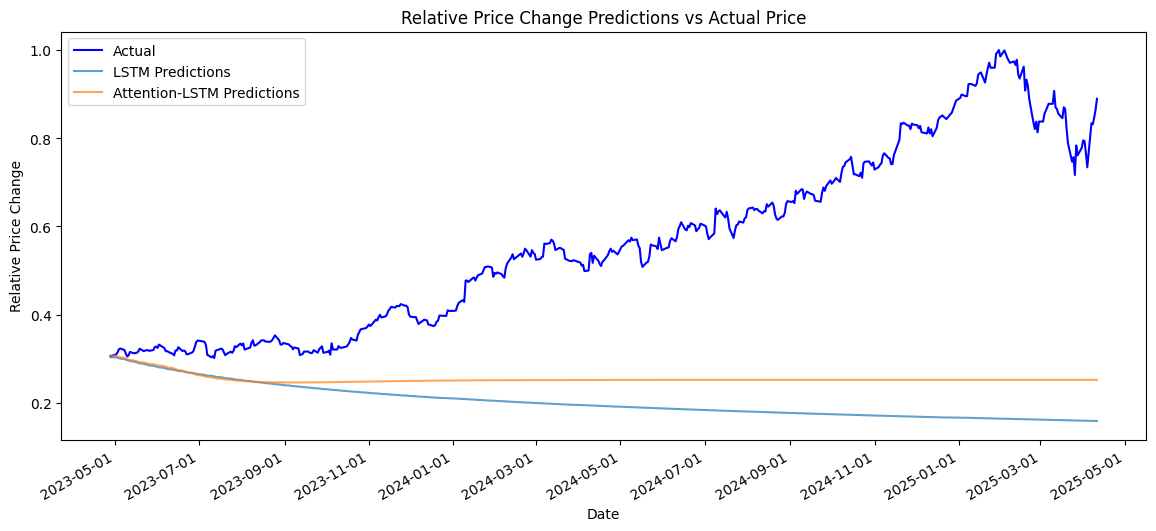

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

start_index = int(len(original_dates) * 0.8)

# Extract the dates corresponding to the test data (for plotting)

dates = original_dates[start_index:start_index + len(y_test.flatten())]

# Create the plot
plt.figure(figsize=(14, 6))

# Plot the actual values and predictions
plt.plot(dates, actual_values, label='Actual', color='blue')
plt.plot(dates, predictions_model, label='LSTM Predictions', alpha=0.7)
plt.plot(dates, predictions_model2, label='Attention-LSTM Predictions', alpha=0.7)

# Add title and labels
plt.title('Relative Price Change Predictions vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Relative Price Change')

# Format the x-axis to display dates correctly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Set interval to 2 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Display the legend
plt.legend()

# Show the plot
plt.show()


Reconstruct & Plot Absolute Prices: Starting from the first actual closing price in the test period, cumulatively apply returns to get price

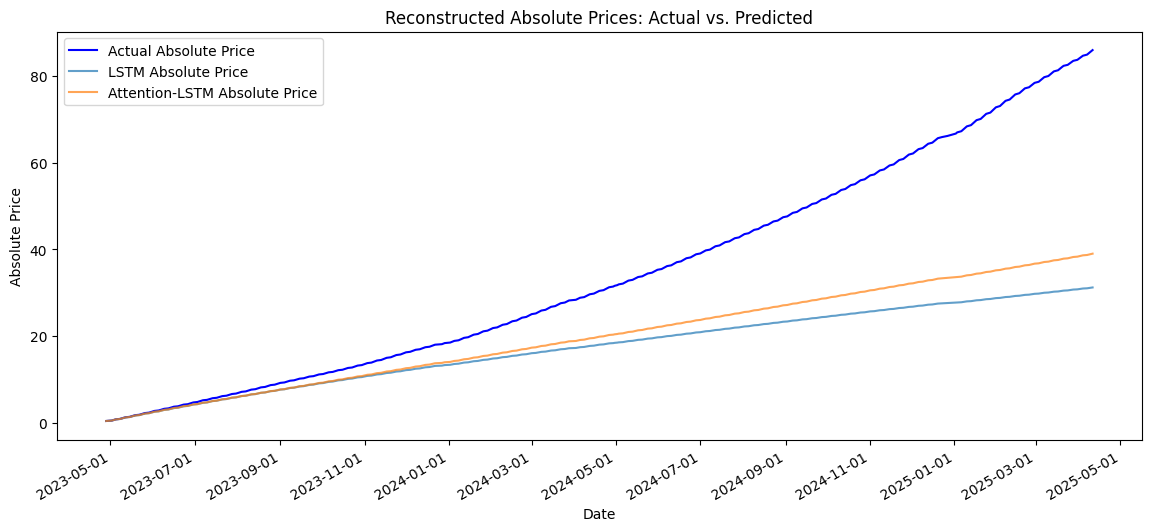

In [ ]:
# Define start_index here
start_index = int(len(original_dates) * 0.8)

# Extract the dates corresponding to the test data
dates = original_dates[start_index: start_index + len(y_test)]

# Reconstruct the absolute prices starting from the first actual value in the test set
initial_price = actual_values[0]

# Reconstructing absolute prices for the actual values
cumulative_changes_actual = np.cumsum(actual_values)
absolute_prices_actual = initial_price * (1 + cumulative_changes_actual)

# Reconstructing absolute prices for model predictions (LSTM)
cumulative_changes_model = np.cumsum(predictions_model)
absolute_prices_model = initial_price * (1 + cumulative_changes_model)

# Reconstructing absolute prices for Attention-LSTM predictions
cumulative_changes_model2 = np.cumsum(predictions_model2)
absolute_prices_model2 = initial_price * (1 + cumulative_changes_model2)  # Apply cumulative relative change

# Plot the actual vs predicted absolute prices
plt.figure(figsize=(14, 6))

# Trim absolute_prices_actual to match dates length if needed
absolute_prices_actual = absolute_prices_actual[:len(dates)]

plt.plot(dates, absolute_prices_actual, label='Actual Absolute Price', color='blue')
plt.plot(dates, absolute_prices_model[:len(dates)], label='LSTM Absolute Price', alpha=0.7)  # Trim to match dates length
plt.plot(dates, absolute_prices_model2[:len(dates)], label='Attention-LSTM Absolute Price', alpha=0.7)  # Trim to match dates length
plt.title("Reconstructed Absolute Prices: Actual vs. Predicted")
plt.xlabel('Date')
plt.ylabel('Absolute Price')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
# Display the legend
plt.legend()

# Show the plot
plt.show()

#Step 6: Experimentation with Sliding Window Sizes



Define Window Sizes and Prepare Metrics Container

In [ ]:
window_sizes = [10, 25, 50, 100] #Define different window sizes to experiment with
results = [] # List to store evaluation results for each window size

# Loop over each window size
for win in window_sizes:

    # Prepare dataset for this window size
    X, y = generate_sliding_window_dataset(stock_data, window_size=win) # Call function, pass test_data, current window size

    # Split the data based on the updated X and y
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = build_model(X_train) # Build a new LSTM model for the current window size
    model.fit(X_train, y_train, epochs=10, verbose=0)# Train the mode

    # Make predictions for the current window size
    predictions = autoregressive_forecast(model, X_test, win)

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    def evaluate(true_values, predictions):
        mse = mean_squared_error(true_values, predictions)
        mae = mean_absolute_error(true_values, predictions)
        return {'MSE': mse, 'MAE': mae}

    metrics = evaluate(y_test.flatten(), predictions) # Evaluate model performance using MSE and MAE

    results.append((win, metrics))  # Store results (window size and metrics)

# Display results for each window size
print("Results for Different Window Sizes:")

for win, met in results:
    print(f"Window {win}: MSE={met['MSE']:.4f}, MAE={met['MAE']:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#  Discussion



#### **Strengths of LSTM Model:**

* The LSTM model captures temporal dependencies well, making it suitable for stock price prediction, where past data influences future prices.
* It performs relatively well with a simple architecture and is easy to train, given its ability to learn from sequential data.

#### **Strengths of LSTM + Attention Model:**

* The attention mechanism allows the model to focus on the most relevant parts of the input sequence, which can improve performance by reducing the influence of less important data points.
* It has the potential to better capture complex patterns in the stock price movement, leading to improved accuracy in some cases.

#### **Weaknesses and Challenges:**

* Both models might struggle with noisy data, as stock prices are highly volatile, and short-term fluctuations can lead to overfitting.

* The models also need careful tuning of hyperparameters like the number of layers, units, and dropout rates, which can be time-consuming.

* The LSTM model, while good for learning long-term dependencies, can still suffer from gradient vanishing or exploding issues, especially when training on longer sequences.

### Analysis of Window Size Experiment Results:

| Window Size | MSE    | MAE    |
| ----------- | ------ | ------ |
| 10          | 0.7270 | 0.7120 |
| 25          | 0.2037 | 0.3784 |
| 50          | 0.3591 | 0.5370 |
| 100         | 0.2176 | 0.3980 |


* **Window 10**: This small window size led to a higher MSE and MAE, suggesting it lacks enough historical context to predict accurately.

* **Window 25**: This window size gave a significant improvement in performance, with lower MSE and MAE, as it captures more information from the past.

* **Window 50**: While this window size is decent, it did not drastically outperform the 25-day window. It indicates that more data does not always lead to better results, as the model might overfit to too much historical information.

* **Window 100**: This window size showed good results, with low MSE and MAE, suggesting that longer windows can help the model predict more accurately, but it still needs careful management to avoid overfitting.

### Suggestions for Improvement:

* **Hyperparameter Tuning**: Fine-tuning the model, especially the number of layers, units, and learning rates, can lead to better performance.

* **Regularization**: Using techniques like L2 regularization or increasing dropout rates could help combat overfitting, especially for larger windows or more complex models.

* **Data Augmentation**: Adding more features or external data, such as economic indicators, could improve model accuracy.

* **Ensemble Models**: Combining the predictions of multiple models could provide more robust and accurate results.
